# Conditional Routing

`add_conditional_edges`

```python
workflow.add_conditional_edges(
    "source_node",
    condition_function,
    {
        "condition1": "target_node1",
        "condition2": "target_node2",
        "default": END
    }
)
```

In [12]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Literal

class State(TypedDict):
    user_input: str

def check_user_input(state: State) -> Literal["question", "command", "unknown"]:
    user_input = state["user_input"].lower()

    if user_input.endswith("?"):
        return "question"
    elif user_input.startswith("!"):
        return "command"
    else:
        return "unknown"

workflow = StateGraph(State)

workflow.add_conditional_edges(
    "parse_input",
    check_user_input,
    {
        "question": "answer_question",
        "command": "execute_command",
        "unknown": "ask_clarification"
    }
)


## 예제

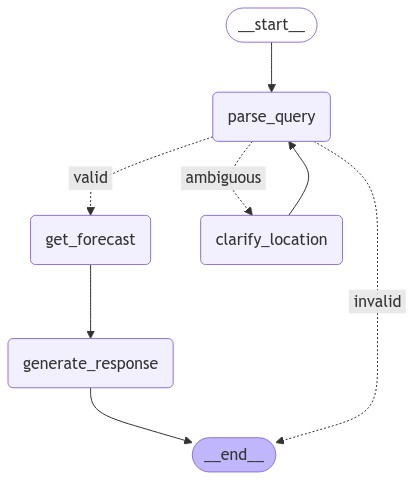

In [13]:
from typing import Literal, Optional, TypedDict
from langgraph.graph import StateGraph, START, END

# Generate Dummy Data
def extract_location(query: str) -> Optional[str]:
    words = query.split()
    if "in" in words:
        index = words.index("in")
        if index + 1 < len(words):
            return words[index + 1]
    return None

def is_ambiguous(location: str) -> bool:
    return len(location) < 3

def fetch_weather_data(location: str) -> str:
    weather_data = {
        "New York": "Sunny, 25°C",
        "London": "Raniy, 15°C",
        "Tokyo": "Cloudy, 20°C",
        "Paris": "Partly cloudy, 22°C"
    }
    return weather_data.get(location, "Weather data not available")

def generate_location_clarification(location: str) -> str:
    return f"Could you please provide more details about the location '{location}'?"

def format_weather_response(location:str, forecast: str) -> str:
    return f"The weather in {location} is: {forecast}"


In [14]:
# Define State
class WeatherState(TypedDict):
    query: str
    location: Optional[str]
    forecast: Optional[str]
    response: str


In [15]:
# Define Nodes
def parse_query(state: WeatherState):
    location = extract_location(state["query"])
    return {"location": location}

def get_forecast(state: WeatherState):
    forecast = fetch_weather_data(state["location"])
    return {"forecast": forecast}

def clarify_location(state: WeatherState):
    clarification = generate_location_clarification(state["location"])
    print(state["location"])
    return {"query": clarification}

def generate_response(state: WeatherState):
    response = format_weather_response(state["location"], state["forecast"])
    return {"response": response}


In [23]:
# Conditional Edge
def check_location(state: WeatherState) -> Literal["valid", "invalid", "ambiguous"]:
    if not state["location"]:
        return "invalid"
    elif is_ambiguous(state["location"]):
        return "ambiguous"
    else:
        return "valid"


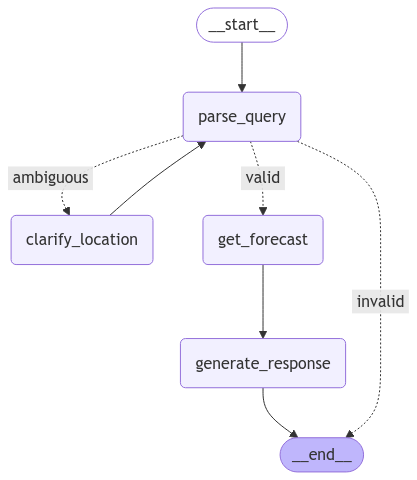

The weather in London is: Raniy, 15°C
The weather in london is: Weather data not available
{'query': "Could you please provide more details about the location 'NY'?", 'location': None}


In [ ]:
# Graph Builder

graph_builder = StateGraph(WeatherState)
graph_builder.add_node("parse_query", parse_query)
graph_builder.add_node("clarify_location", clarify_location)
graph_builder.add_node("get_forecast", get_forecast)
graph_builder.add_node("generate_response", generate_response)

graph_builder.add_edge(START, "parse_query")
graph_builder.add_edge("clarify_location", "parse_query")
graph_builder.add_edge("get_forecast", "generate_response")
graph_builder.add_edge("generate_response", END)

graph_builder.add_conditional_edges(
    "parse_query",
    check_location,
    {
        "valid": "get_forecast",
        "invalid": END,
        "ambiguous": "clarify_location"
    }    
)

app = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

result = app.invoke({"query": "How is it in London"})
print(result["response"])

result = app.invoke({"query": "How is it in london"})
print(result["response"])

result = app.invoke({"query": "How is it in NY"})
print(result)